In [18]:
from collections import namedtuple
from itertools import starmap
from matplotlib import ticker, gridspec
from typing import cast, Unpack
from math import ceil

import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys

from collections import defaultdict

In [19]:
# Allow imports from parent folder
sys.path.append("..")

from compute_structures import *
from error_functions import mean_squared_error as MSE
from error_functions import root_mean_squared_error as RMSE
from error_functions import mean_absolute_relative_error as MARE
from error_functions import symmetric_mean_absolute_relative_error as SMARE
from error_functions import symmetric_mean_absolute_relative_error_alt as SMARE_alt
from error_functions import mean_my_error as mean_my_err
from error_functions import mean_log_relative_error as mean_log_err

from error_functions import absolute_error as abs_err
from error_functions import relative_error as rel_err
from error_functions import symmetric_relative_error as sym_rel_err
from error_functions import symmetric_relative_error_alt as sym_rel_err_alt
from error_functions import log_relative_error as log_rel_err
from error_functions import log_absolute_error as log_abs_err
from error_functions import squared_error as sq_err
from error_functions import my_error as my_err

In [20]:
stats_folder = "../stats/"


in_file = "training"

## Setting Up the Data

In [21]:
from typing import Literal, NamedTuple, NotRequired

class OverrideSetting(TypedDict):
    stats_type: StatType
    prune_strat: tuple[PruneStrat]
    sampling_rate: float
    num_histogram_buckets: NotRequired[int]

class DataRow(NamedTuple):
    override_settings: OverrideSetting
    error_data: list[float]
    actual_data: dict[str, tuple[list[int], list[int]]]
    meta_data: dict

Data = list[DataRow]

In [22]:
stats_data_path = stats_folder + in_file + "_analysis.pickle"
with open(stats_data_path, "rb") as f:
    data = pickle.load(f)

# Process the data to make it easier to work with
for i in range(len(data)):
    row = data[i]
    # Make lists into tuples so they can be dict keys
    ov_sets = row[0]
    if "prune_strats" in ov_sets:
        ov_sets["prune_strats"] = tuple(ov_sets["prune_strats"])

    # Split truth and estimate into separate lists, instead of keeping them as pairs
    actual_data = row[2]
    for k, v in actual_data.items():
        actual_data[k] = tuple(zip(*v))

    # Turn the row into a DataRow
    data[i] = DataRow(*row)

data = cast(Data, data)

In [23]:
override_settings, error_data, actual_data, meta_data = zip(*data)

# Allow access to results data using string of override settings used when collecting the results data
data_by_settings = {str(row[0]): row[1:] for row in data}

def group_data_by(group_val_key: Literal["prune_strats", "stats_type", "sampling_rate"]) -> dict[OverrideSetting, Data]:
    grouped = defaultdict(list)
    for row in data:
        key_val = row.override_settings[group_val_key]
        grouped[key_val].append(row)

    return grouped

data_by_stats = group_data_by("stats_type")
data_by_pruning = group_data_by("prune_strats")
data_by_sampling = group_data_by("sampling_rate")

In [24]:
# None => allow only where key is not defined
# '*' => allow any value
# <value> => matching value
# ! Does not handle when value is None, but I don't think that can every happen here
class OverrideSettingKwargs(OverrideSetting, total=False): pass
def get_by_settings(**kwargs: Unpack[OverrideSettingKwargs]):
    def settings_filter(data_row: DataRow):
        ov_sets = data_row.override_settings
        for key, val in kwargs.items():
            if val != '*':
                if val is None and key in ov_sets:
                    return False
                if key not in ov_sets or ov_sets[key] != val:
                    if key in ov_sets:
                        assert type(val) == type(ov_sets[key]), f"{val} vs. {ov_sets[key]}"
                    return False
        return True

    return list(filter(settings_filter, data))

## Visualization Functions

In [25]:
def translate_label(label: str) -> str:
    return (
        {
            "eq": "EQ (=)",
            "lt": "LT (<)",
            "gt": "GT (>)",
            "is_null": "is null",
            "is_not_null": "is not null",
            "memberof": "mem",
            "contains": "con",
            "overlaps": "int",
        } | {
            str(stype): str(stype).split(".")[1]  for stype in StatType
        }
    ).get(label, label)

def pretty_err_func(errfunc) -> str:
    if errfunc == log_rel_err:
        return "Log Relative Error " + r'[$\log(\frac{C_{est}}{C_{true}})$]'
    if errfunc == sym_rel_err:
        return "Symmetric Relative Error " + r'[$\frac{|C_{true} - C_{est}|}{|C_{true} + C_{est}|})$]'

    return errfunc.__name__
    
def format_title(stats_type=None, num_hist_bucks=None, short=False):
    out = ""
    if stats_type:
        stat_name = str(stats_type).split(".")[1]
        if short:
            out += "".join([s[0] for s in stat_name.split("_")])
        else:
            out += stat_name

        if num_hist_bucks:
            out += f"[{num_hist_bucks}]"

    return out

In [120]:
def _ax_boxplot(ax, datas, x_labels=None, title=None, ylim=None, is_log=True, showfliers=False):
    x_labels = list(map(translate_label, x_labels))

    ax.boxplot(
        datas, 
        labels=x_labels, 
        showfliers=showfliers, 
        medianprops={"linewidth": 2},
        flierprops={"marker": ".", },
    )
    # ax.violinplot(datas, showmedians=True, showextrema=True)
    # plt.xticks(ticks=plt.xticks()[0], labels=[""] + x_labels + [""])
    
    ax.set_title(title)
    ax.set(ylim=ylim)
    
    if is_log:
        # Make sure there are no more ticks than unique values on the y axis ticks
        bottom = min(plt.ylim()[0], -1)
        top = max(plt.ylim()[1], 1)
        ax.set(ylim=(bottom, top))
        y_tick_range = top - bottom
        if y_tick_range >= 3:
            plt.locator_params(nbins=top - bottom, axis='y')
            ax.yaxis.set_major_formatter(lambda x, _pos: f"$10^{{{int(x)}}}$")
        else:
            ax.yaxis.set_major_formatter(lambda x, _pos: f"${10**x:.2f}$")
            ax.yaxis.set_major_formatter(lambda x, _pos: f"$10^{{{x:.2f}}}$")
    
    ax.grid(visible=True, linewidth=0.5)

def boxplot(error_collection: dict[str, list[float]], title=None, ylim=None, **kwargs):  
    errors = list(error_collection.values())
    x_labels = list(error_collection.keys())

    fig, ax = plt.subplots()
    _ax_boxplot(ax, errors, x_labels=x_labels, title=title, ylim=ylim, **kwargs)

    plt.show()


def multiple_boxplots(datas: list[dict[str, list[float]]], titles=[], layout=None, ylim=None, **kwargs):
    if titles:
        assert len(titles) == len(datas)

    n_rows, n_cols = layout if layout else (ceil(len(datas)/3), 3)

        
    num_vertical_items = len(datas[0])
    fig = plt.figure(tight_layout=True, figsize=[num_vertical_items*3, 9])  # default figsize=[6.4, 4.8] ([width, height] in inches)
    gs = gridspec.GridSpec(n_rows, n_cols)

    for grid_idx, err_coll in enumerate(datas):
        grid_item = gs[grid_idx//n_cols, grid_idx%n_cols]

        ax = fig.add_subplot(grid_item)

        errors = list(err_coll.values())
        x_labels = list(err_coll.keys())
        _ax_boxplot(ax, errors, x_labels=x_labels, title=titles[grid_idx] if titles else None, ylim=ylim, **kwargs)

### Plotting the different error measurements [histogram(*), K sampling, no pruning]: equality

This can be used to show the impact that increasing the number of histogram buckest has.

In [121]:
# Histograms only
hist_no_sampling_no_pruning = get_by_settings(stats_type=StatType.HISTOGRAM, prune_strats=tuple(), sampling_rate=0.9)

# All statistics types -- multiple histograms
# hist_no_sampling_no_pruning = get_by_settings(prune_strats=tuple(), sampling_rate=0.9)

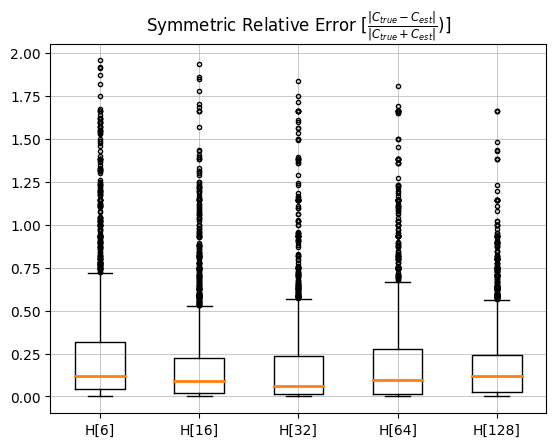

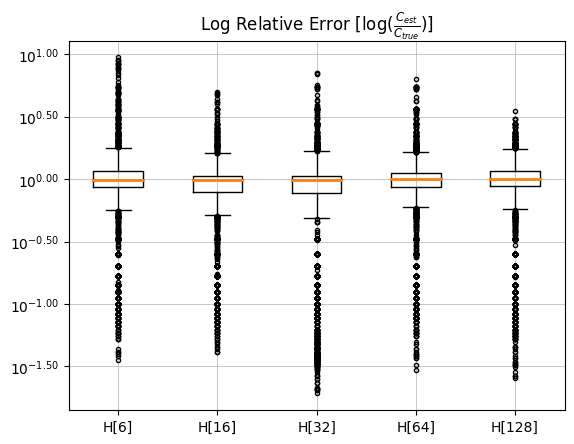

In [122]:
error_funcs = [
    MSE, RMSE, MARE, SMARE, SMARE_alt, mean_my_err, mean_log_err
]
for err_func in error_funcs:
    result = {}
    for config_case in hist_no_sampling_no_pruning:
        test_data = config_case.actual_data
        
        errors = {}
        for operator, op_results in test_data.items():
            if not op_results: continue
            
            errors[operator] = err_func(*op_results)

        if "num_histogram_buckets" in config_case.override_settings:
            results_key = config_case.override_settings["num_histogram_buckets"]
        else:
            results_key = config_case.override_settings["stats_type"]
        result[results_key] = errors


    df = pd.DataFrame(result)
    # df.plot(title=err_func.__name__)


error_funcs = [
    sym_rel_err, log_rel_err, 
    # rel_err, my_err, sym_rel_err_alt
    # abs_err, log_abs_err, sq_err,  # <-- bad error measures
]
for err_func in error_funcs:
    results = {}
    for config_case in hist_no_sampling_no_pruning:
        test_data = config_case.actual_data
        
        op_results = test_data["lt"]
        errors = pd.Series(list(starmap(err_func, zip(*op_results))))
        # Outlier removal
        q = errors.quantile(0.995)
        errors = errors[errors < q]

        results_key = format_title(
            stats_type=config_case.override_settings["stats_type"],
            num_hist_bucks=config_case.override_settings.get("num_histogram_buckets"),
            short=True,
        )
        results[results_key] = errors


    boxplot(
        results,
        title=pretty_err_func(err_func),
        is_log=(err_func == log_rel_err),
        showfliers=True
    )

    # df = pd.DataFrame(results)
    # ax = df.plot(
    #         kind="box", 
    #         title=pretty_err_func(err_func), 
    #         grid={"visible": True}, 
    #         flierprops={"marker": ".", },
    #         # showfliers=False,
    #         figsize=(2*len(results), 6)
    # )
    # fig = ax.get_figure()
    # fig.savefig()

### Plotting the operators against each other with log relative error

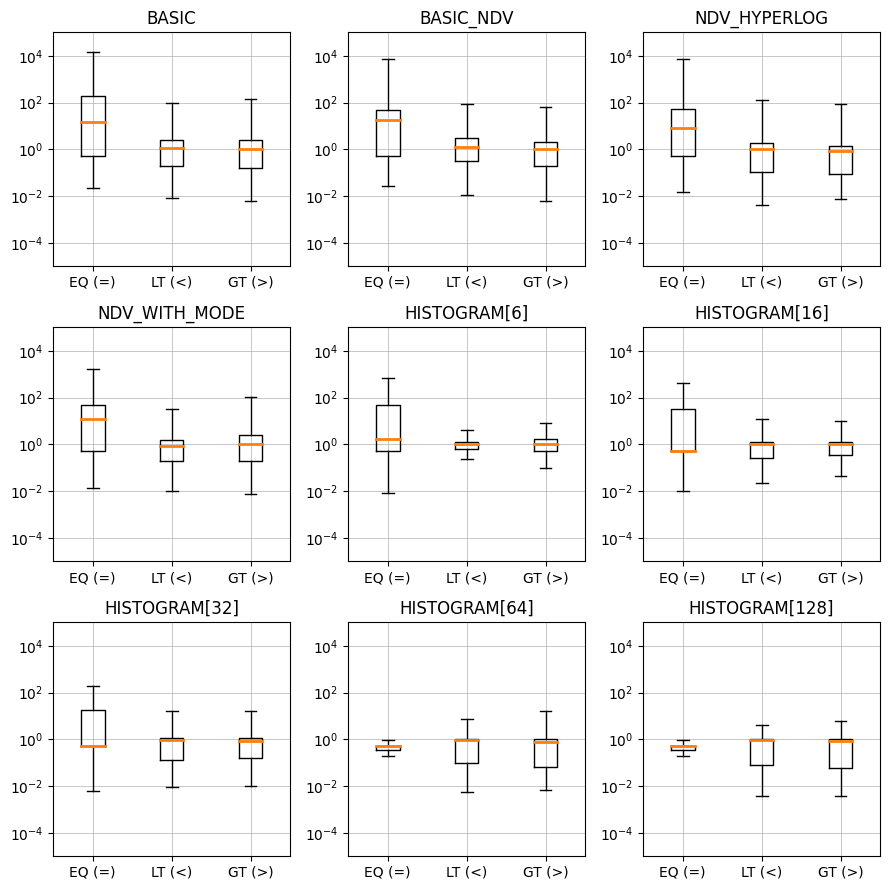

In [29]:
data_rows = get_by_settings(prune_strats=tuple(), sampling_rate=0.98)[:9]


all_errs = []
titles = []
for datarow in data_rows:
    test_data = datarow.actual_data

    collected_errors = {}
    for operator, op_results in test_data.items():
        if not op_results: continue
        if operator in ("exists", "is_null", "is_not_null"): continue
        
        err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        q = err_series.quantile(0.999)
        err_series = err_series[err_series < q]
        
        collected_errors[operator] = err_series

    all_errs.append(collected_errors)
    ov_sets = datarow.override_settings
    titles.append(format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets")))

multiple_boxplots(all_errs, titles, ylim=(-5, 5))


# # Plot them in separate plots
# for datarow in data_rows:
#     test_data = datarow.actual_data

#     collected_errors = {}
#     for operator, op_results in test_data.items():
#         if not op_results: continue
#         err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
#         q = err_series.quantile(0.999)
#         err_series = err_series[err_series < q]

#         collected_errors[operator] = err_series

    # boxplot(
    #     collected_errors, 
    #     title=format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets")),
    #     ylim=(-5, 5),
    # )

### BASIC_NDV vs NDV_HYPERLOG

In [ ]:
data_rows = get_by_settings(prune_strats=tuple(), sampling_rate=0.98)[:9]

all_errs = []
titles = []
for datarow in data_rows:
    test_data = datarow.actual_data

    collected_errors = {}
    for operator, op_results in test_data.items():
        if not op_results: continue
        if operator in ("exists", "is_null", "is_not_null"): continue
        
        err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        q = err_series.quantile(0.999)
        err_series = err_series[err_series < q]
        
        collected_errors[operator] = err_series

    all_errs.append(collected_errors)
    ov_sets = datarow.override_settings
    titles.append(format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets")))

multiple_boxplots(all_errs, titles)